In [2]:
from gaussian_fermions import *
#import gaussian_fermions as gf

from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize as optimize
from matplotlib import rc
import functools as fc
import re
import sys
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
#plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['font.size'] = 35
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

from class_quench_tomography import *


In [3]:
L = 20
beta = 3
H_nnh = nearest_neighbor_hopping( L )

In [6]:
from scipy.linalg import block_diag
###
#Entanglement analysis
#
def mplogp( p ):
    if p < 1e-16:
        #print p, "cutting"
        return 0
    return - p * np.log( p )  / np.log(2)

def S_vN( cov ):
    if cov.shape[0] == 1:
        return  mplogp( cov[0][0] ) + mplogp( cov[0][0] )
    ns, R = np.linalg.eigh( cov )
    return  sum( [ mplogp( n ) + mplogp( 1-n ) for n in ns ] )

def entanglement_lower_bound(  cov_AB, A ):
    cov_A = cov_AB[ np.ix_( A, A ) ]
    return  S_vN( cov_A ) - S_vN( cov_AB )

def entanglement_cost_Gaussian_lower_bound( cov, A, B, save_plot_path = None, beta = None, show_plots = None, save_path = None ):
    #Indices of subsystems
    AB = A + B
    print(A,B)
    #Covariance matrices
    cov_AB = cov[ np.ix_( AB,AB) ]
    cov_A = cov[ np.ix_( A,A) ]
    cov_B = cov[ np.ix_( B,B) ]

    #Spectra and diagonalization of A and B
    p_A, U_A = np.linalg.eigh( cov_A )
    p_B, U_B = np.linalg.eigh( cov_B )
    U_A = U_A.T.conj()
    U_B = U_B.T.conj()

    #Distillation heuristic
    U = block_diag( U_A, U_B )
    #A and B correlations after local operations
    cov_X = U.dot( cov_AB.dot( U.T.conj() ) )

    
    max_a = 0
    max_b = 0
    max_E_G = None
    max_cov = [[0,0],[0,0]]
    max_S1 = None
    for j in range( len(A) ):
        for k in range( len(B) ):
            ab=[A[j],B[k]]
            cov_test= cov_X[ np.ix_( ab,ab) ]
            E_G_jk = entanglement_lower_bound( cov_test, [0] )
            if E_G_jk is None:
                print j,k
            if E_G_jk > max_E_G:
                max_E_G = E_G_jk
                max_a = A[j]
                max_b = B[k]
                max_cov = cov_test
                max_S1 = S_vN( cov_test )
    max_a2 = 0
    max_b2 = 0
    max_E_G2 = None
    max_cov2 = np.zeros((2,2))
    max_S2 = None
    for j in range( len(A) ):
        for jj in range( j+1, len(A) ):
            for k in range( len(B) ):
                for kk in range( k+1, len(B) ):
                    ab=[A[j],A[jj],B[k],B[kk]]
                    cov_test= cov_X[ np.ix_( ab,ab) ]
                    E_G_jk = entanglement_lower_bound( cov_test, [0,1] )
                    if E_G_jk is None:
                        print j,k,jj,kk
                    if E_G_jk > max_E_G2:
                        max_E_G2 = E_G_jk
                        max_a2 = [A[j],A[jj]]
                        max_b2 = [B[k],B[kk]]
                        max_cov2 = cov_test
                        max_S2 = S_vN( cov_test )

    print( max_a,max_b, max_E_G, max_cov )
    print( max_a2, max_b2, max_E_G2, max_cov2 )

    if show_plots is not None:
        fig = plt.figure( figsize = ( 21, 22 ) )
        
        ax = fig.add_subplot(151)
        plt.title('Full cov')
        im1 = plt.imshow( cov )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)        
        cbar1 = plt.colorbar(im1, cax=cax)
#         cbar1.set_clim( -1, 1 )

        im2 = ax = fig.add_subplot(152)
        plt.title('Cov A')
        im2 = plt.imshow( cov_A )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)        
        cbar2 = plt.colorbar(im2, cax=cax)
#         cbar2.set_clim( -1, 1 )        
        
        ax = fig.add_subplot(153)
        plt.title('Cov B')
        im3 = plt.imshow( cov_B )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)        
        cbar3 = plt.colorbar(im3, cax=cax)
#         cbar3.set_clim( -1, 1 )        
        
        ax = fig.add_subplot(154)
        plt.title('Full cov rotated')
        im4 = plt.imshow( cov_X )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)        
        cbar4 = plt.colorbar(im4, cax=cax)
#         cbar4.set_clim( -1, 1 )
        
        ax = fig.add_subplot(155)
        plt.title('Selected 2 A-B modes')
        im5 = plt.imshow( block_diag( max_cov, max_cov2 ) )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)        
        cbar5 = plt.colorbar(im5, cax=cax)
#         cbar5.set_clim( -1, 1 )        
        
        plt.tight_layout()
        if save_path is not None:
            plt.savefig( save_path, format='pdf')
        plt.show()


    return max_E_G, max_E_G2, cov_X, max_cov, [max_a, max_b]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(0, 10, -0.9999999999999991, array([[5.0000000e-01, 1.1995712e-16],
       [1.1995712e-16, 5.0000000e-01]]))
([0, 1], [10, 11], -2.0, array([[ 5.00000000e-01,  2.39936852e-17,  1.19957120e-16,
        -3.11105195e-17],
       [ 3.61130534e-17,  5.00000000e-01, -2.10139911e-17,
         9.51127628e-17],
       [ 1.19957120e-16, -2.10139911e-17,  5.00000000e-01,
         4.09700989e-17],
       [-3.11105195e-17,  9.51127628e-17,  6.19871234e-17,
         5.00000000e-01]]))


/home/marek/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


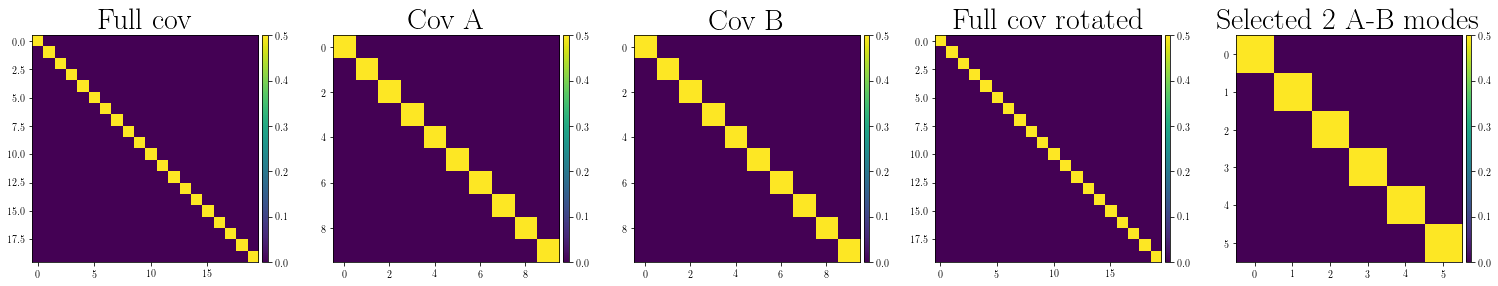

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(1, 19, -0.3412975969324332, array([[0.15851201, 0.00388527],
       [0.00388527, 0.87157296]]))
([4, 5], [10, 19], -1.1043108257182788, array([[ 4.31202627e-01,  4.15472129e-17, -7.59893892e-03,
        -8.36172787e-03],
       [ 2.91474641e-17,  5.68797373e-01, -8.36172787e-03,
        -7.59893892e-03],
       [-7.59893892e-03, -8.36172787e-03,  1.28427037e-01,
        -1.37889435e-17],
       [-8.36172787e-03, -7.59893892e-03, -5.63735967e-17,
         8.71572963e-01]]))


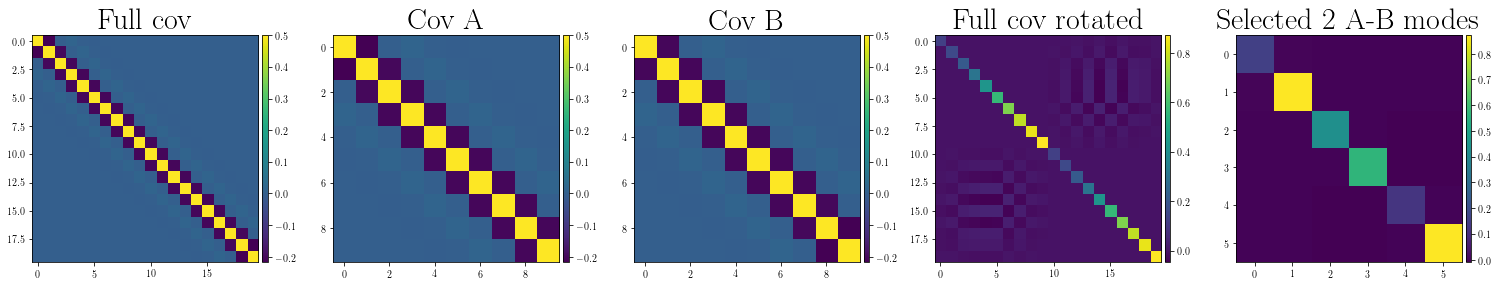

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(3, 19, 0.1644104401996861, array([[0.10262015, 0.00388759],
       [0.00388759, 0.99661318]]))
([4, 5], [10, 19], -0.06490742243150471, array([[ 3.27447462e-01, -1.40268842e-17,  1.04144751e-03,
         3.72753875e-03],
       [-2.93226003e-17,  6.72552538e-01,  3.72753875e-03,
         1.04144751e-03],
       [ 1.04144751e-03,  3.72753875e-03,  3.38682451e-03,
         6.32867153e-17],
       [ 3.72753875e-03,  1.04144751e-03,  2.69294551e-17,
         9.96613175e-01]]))


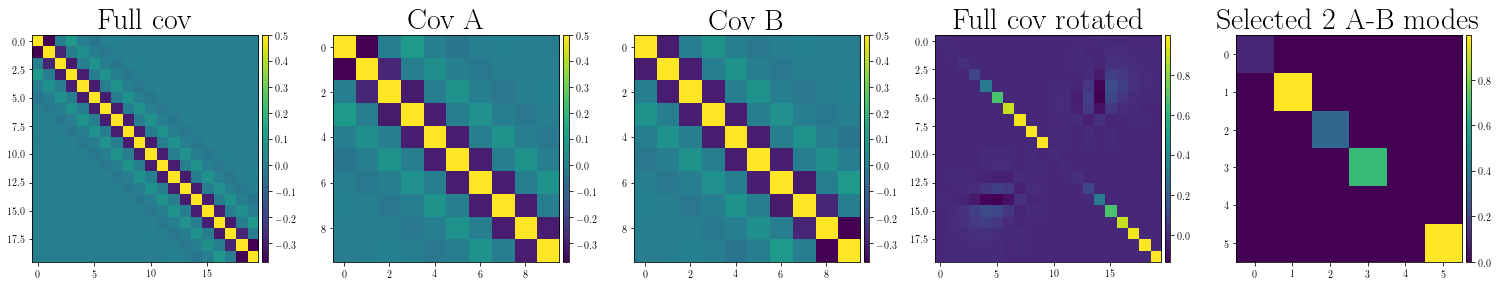

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(4, 19, 0.1797668882043112, array([[ 2.65299754e-01, -6.35364380e-04],
       [-6.35364380e-04,  9.99910585e-01]]))
([3, 6], [10, 19], -0.0026096946648325736, array([[ 4.04583683e-02, -8.44905173e-17, -1.14883972e-04,
         1.12520188e-03],
       [-1.07506760e-16,  9.59541632e-01, -1.12520188e-03,
         1.14883972e-04],
       [-1.14883972e-04, -1.12520188e-03,  8.94151101e-05,
        -5.94144420e-17],
       [ 1.12520188e-03,  1.14883972e-04,  8.98910483e-18,
         9.99910585e-01]]))


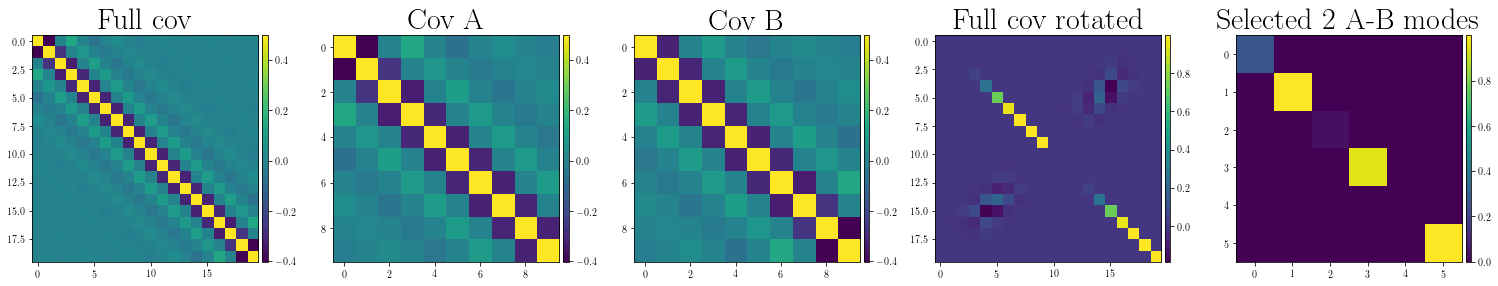

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(4, 19, 0.2088523804136443, array([[ 1.90683632e-01, -2.93283314e-05],
       [-2.93283314e-05,  9.99999964e-01]]))
([3, 6], [10, 19], -1.7144378089140044e-06, array([[ 9.88193189e-03, -3.45864415e-16,  1.22692344e-07,
         5.29143593e-05],
       [-4.07090499e-16,  9.90118068e-01, -5.29143591e-05,
        -1.22692354e-07],
       [ 1.22692344e-07, -5.29143591e-05,  3.61613718e-08,
         8.47923150e-17],
       [ 5.29143593e-05, -1.22692354e-07,  1.91367998e-16,
         9.99999964e-01]]))


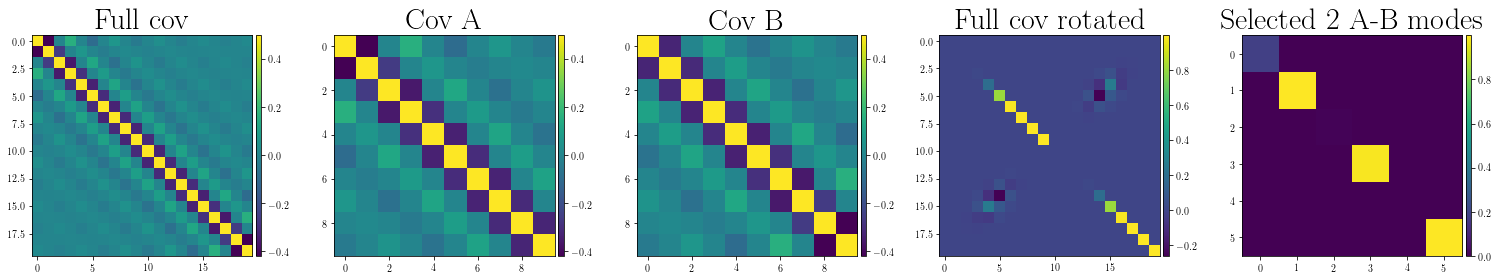

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(4, 15, 0.29699492843880837, array([[ 0.15668329, -0.29660306],
       [-0.29660306,  0.84331671]]))
([4, 5], [14, 15], 0.34373834152174243, array([[ 1.56683289e-01, -3.17930102e-16,  4.51171150e-02,
        -2.96603060e-01],
       [-2.43875192e-16,  8.43316711e-01, -2.96603060e-01,
         4.51171150e-02],
       [ 4.51171150e-02, -2.96603060e-01,  1.56683289e-01,
         5.95899121e-17],
       [-2.96603060e-01,  4.51171150e-02,  8.18629039e-17,
         8.43316711e-01]]))


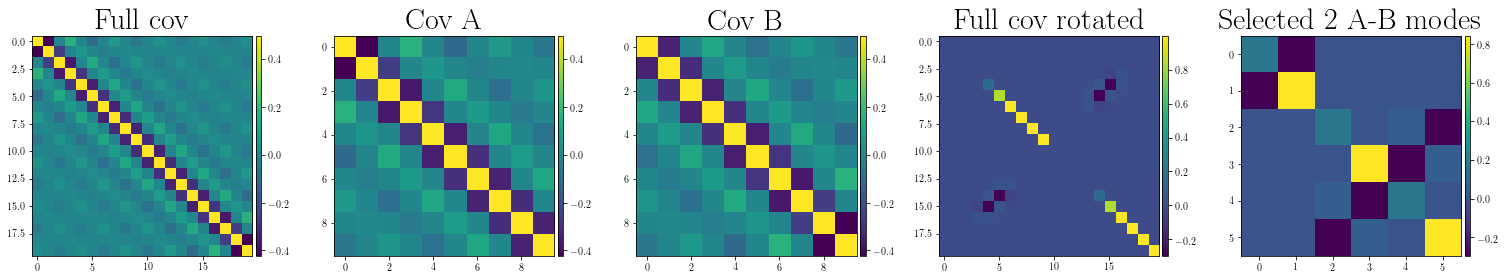

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(4, 15, 0.4843292165231037, array([[ 0.13943603, -0.31335674],
       [-0.31335674,  0.86056397]]))
([4, 5], [14, 15], 0.6350173074571238, array([[ 1.39436030e-01,  2.01649569e-17,  2.20456944e-02,
        -3.13356736e-01],
       [ 9.42620688e-17,  8.60563970e-01,  3.13356736e-01,
        -2.20456944e-02],
       [ 2.20456944e-02,  3.13356736e-01,  1.39436030e-01,
         2.15019565e-16],
       [-3.13356736e-01, -2.20456944e-02,  3.45710828e-16,
         8.60563970e-01]]))


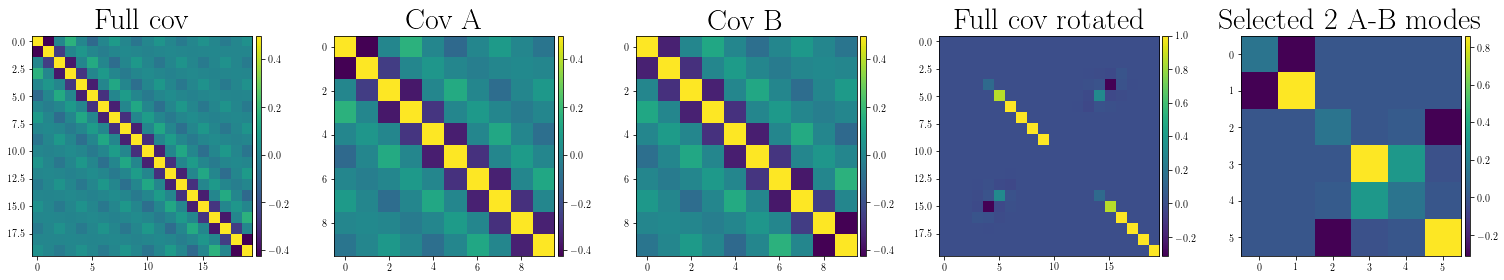

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(4, 15, 0.7211342055168893, array([[ 0.12385962, -0.32771019],
       [-0.32771019,  0.87614038]]))
([4, 5], [14, 15], 1.0345989268007116, array([[ 1.23859620e-01, -1.01938821e-16,  1.12500347e-03,
        -3.27710189e-01],
       [-1.10544098e-16,  8.76140380e-01,  3.27710189e-01,
        -1.12500347e-03],
       [ 1.12500347e-03,  3.27710189e-01,  1.23859620e-01,
         6.05129516e-17],
       [-3.27710189e-01, -1.12500347e-03,  8.18219671e-17,
         8.76140380e-01]]))


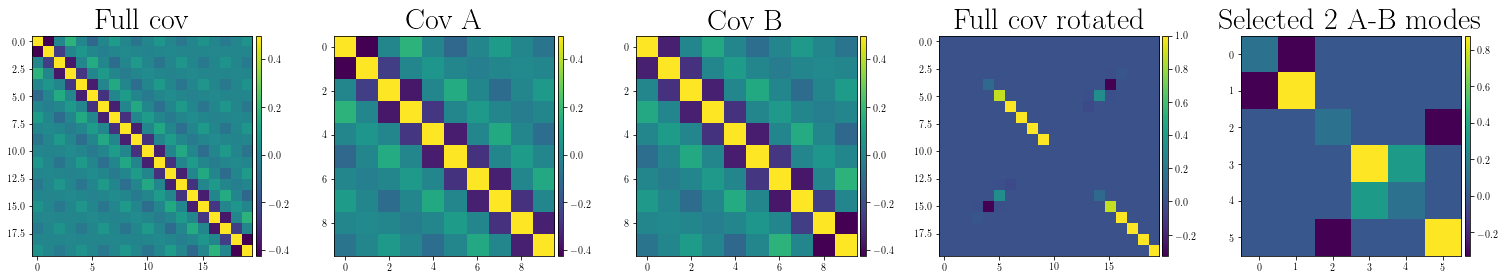

[-0.9999999999999991, -0.3412975969324332, 0.1644104401996861, 0.1797668882043112, 0.2088523804136443, 0.29699492843880837, 0.4843292165231037, 0.7211342055168893]
[-2.0, -1.1043108257182788, -0.06490742243150471, -0.0026096946648325736, -1.7144378089140044e-06, 0.34373834152174243, 0.6350173074571238, 1.0345989268007116]


In [9]:
betas = [0,1, 3,5,10,15,L, 2*L]

E_G1s = []
E_G2s = []
S_beta = []
for beta in betas:
    cov = H_nnh.cov_thermal( beta )
    S_beta.append( S_vN(cov) )
    E_G1, E_G2, cov_X, cov_sub, sub_idx =  entanglement_cost_Gaussian_lower_bound( cov, range(L/2),range(L/2,L), show_plots = 21 )
    E_G1s.append(E_G1)
    E_G2s.append(E_G2)
    
print( E_G1s )
print( E_G2s )

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
(4, 15, 0.4843292165231037, array([[ 0.13943603, -0.31335674],
       [-0.31335674,  0.86056397]]))
([4, 5], [14, 15], 0.6350173074571238, array([[ 1.39436030e-01,  2.01649569e-17,  2.20456944e-02,
        -3.13356736e-01],
       [ 9.42620688e-17,  8.60563970e-01,  3.13356736e-01,
        -2.20456944e-02],
       [ 2.20456944e-02,  3.13356736e-01,  1.39436030e-01,
         2.15019565e-16],
       [-3.13356736e-01, -2.20456944e-02,  3.45710828e-16,
         8.60563970e-01]]))


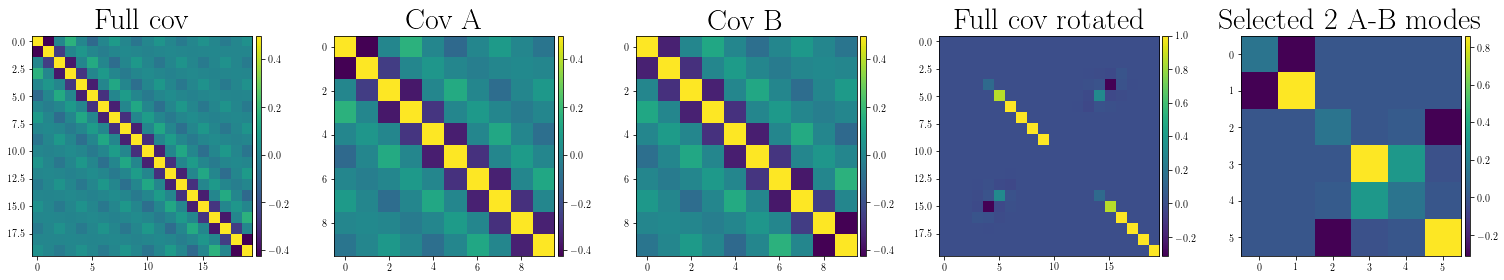

In [10]:
cov = H_nnh.cov_thermal( 20 )
E_G1, E_G2, cov_X, cov_sub, ab  =  entanglement_cost_Gaussian_lower_bound( cov, range(L/2),range(L/2,L), show_plots = 21 )


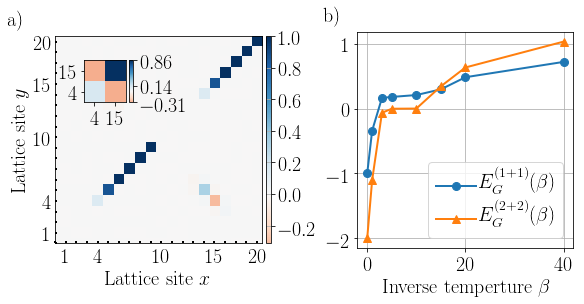

In [19]:
L = 20
#Main plot
fig = plt.figure( figsize = ( 20,20 ) )
fontsize = 20
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize

length = 0.15

cov_pos_x  = 0.06
cov_pos_y = .2
cov_height = length
cov_width = length

data_pos_x  = 1.8*cov_width
data_pos_y = .2
data_height = length
data_width = length

inset_pos_x = cov_pos_x + 0.02
inset_pos_y = cov_pos_y + 0.657*cov_height   
inset_height = 0.23*cov_height
inset_width = inset_height

label_a_x = -9
label_a_y = 1.35
label_b_x = -4
label_b_y = 21 

ax = fig.add_axes( [ data_pos_x, data_pos_y, data_width, data_height ] )   
plt.text( label_a_x,label_a_y, 'b)')

ax.plot(betas,  E_G1s, '-o', label = r'$E_G^{(1+1)}(\beta)$')
ax.plot(betas,  E_G2s, '-^', label = r'$E_G^{(2+2)}(\beta)$')
# ax.set_aspect(15)
# ax.set_ylim([0,2.5])
plt.legend()
plt.xlabel( r'Inverse temperture $\beta$' )

ylabels = [0,1,2]
# plt.yticks( [0,1,2], ylabels )
# ax.set_ylim([-.5,1.5])
plt.grid()



ax2 = fig.add_axes( [ cov_pos_x, cov_pos_y, cov_width, cov_height ] )  
plt.text( label_b_x,label_b_y, 'a)')

x = range(0,L)
im_cov_X = ax2.imshow( (cov_X), cmap='RdBu', interpolation = None, extent = [ 0, L, L, 0])
# plt.grid()
# title = r'After local operations'
# plt.title( title )
plt.xlim((1,L))
plt.ylim((1,L))
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Lattice site $y$' )

ticks = range(L)
tick_labels = ['']*(L)
tick_labels[1] = 1
tick_labels[ab[0]] = ab[0]
tick_labels[ab[1]] = ab[1]
tick_labels[L/2] = L/2
tick_labels[-1] = L
ticks = range(L)
plt.xticks(np.array(ticks)-L/(L+1)+.5,tick_labels)
plt.yticks(np.array(ticks)-L/(L+1)+.5,tick_labels)

plt.tick_params(direction='in', length=2, width=2, colors='k')

divider = make_axes_locatable( ax2 )
cax_cov_rec = divider.append_axes("right", size="2.5%", pad=0.05)

cbar = plt.colorbar( im_cov_X, cax = cax_cov_rec )
range_plot = np.max( np.abs( cov_X ) )
cbar.set_clim( -range_plot, range_plot )
plt.grid()
#inset 
inset = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im2 = inset.imshow( cov_sub, extent = [ 1, 2,2, 1], cmap='RdBu', aspect='equal', interpolation = None)
plt.xlim((1,2))
plt.ylim((1,2))
plt.xticks( [1.25,1.75], ab )
plt.yticks( [1.25,1.75], ab )

divider2 = make_axes_locatable(inset)
cax_cov_rec2 = divider2.append_axes("right", size="10%", pad=0.05)
cbar2 = plt.colorbar(im2, cax = cax_cov_rec2 )
range_plot = np.max( np.abs( cov_sub ) )
cbar2.set_clim( -range_plot, range_plot )

cbar2.set_ticks( [round(cov_sub[0,0],2),round(cov_sub[0,1],2),round(cov_sub[1,1],2)])

plt.savefig( 'figs/thermal_entanglement_cost_L_' + str(L) + '.pdf', format='pdf')
plt.show()

In [219]:
round(cov_sub[0,0],2)

0.14

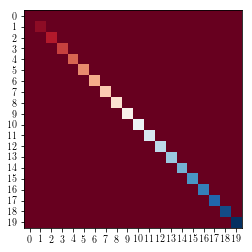

In [194]:
A = np.diag(range(0,L))
fig = plt.figure()
plt.imshow( A, cmap='RdBu',extent = [0,L,L,0])
ticks = range(L)
plt.xticks(np.array(ticks)+L/(L+1)+.5,ticks)
plt.yticks(np.array(ticks)+L/(L+1)+.5,ticks)


plt.show()

In [136]:
0.5+np.array([1,2])

array([1.5, 2.5])

In [18]:
np.log(2)/2


0.34657359027997264

In [32]:
cov = np.array([[1,1],[1,1]])/2.
E_G = entanglement_cost_Gaussian_lower_bound( cov, range(1),range(1,2))

print mplogp(1/2.)
print S_vN( cov )
print S_vN( cov[0:1,0:1])

([0], [1])
(0, 1, 1.0, array([[0.5, 0.5],
       [0.5, 0.5]]))
(0, 0, None, array([[0., 0.],
       [0., 0.]]))
0.5
0.0
1.0


$| \varphi\rangle = \frac 1{\sqrt 2} (|01\rangle+|10\rangle)$

$\Gamma_{1,1} = \langle\varphi| \hat N_1|\varphi\rangle = \frac 12 \langle10| \hat N_1|10\rangle  = 1/2$

$\Gamma_{1,2} = \langle\varphi| \hat f_1^\dagger f_2 |\varphi\rangle = \frac 12 \langle\varphi| 10\rangle  = 1/2$

$\hat f_1^\dagger f_2 |\varphi\rangle = \frac12 \hat f_1^\dagger f_2 f_2^\dagger |\emptyset\rangle=\frac12 \hat  |10\rangle$

$\hat f_2^\dagger f_1 |\varphi\rangle = | 01\rangle$


In [33]:
cov_gnd = H_nnh.cov_gnd()
print S_vN(cov_gnd)
print entanglement_cost_Gaussian_lower_bound(cov_gnd, range(L/2),range(L/2,L))
     

[(1.0, -1.985417748196108), (1.0, -1.941883634852104), (1.0, -1.8700324853708297), (1.0, -1.7709120513064196), (1.0, -1.6459677317873127), (1.0, -1.4970214963422022), (1.0, -1.3262453164815902), (1.0, -1.1361294934623116), (1.0, -0.9294463440875368), (1.0, -0.7092097740850712), (1.0, -0.4786313285751162), (1.0, -0.2410733605106452), (1.0, -1.3672625270457053e-16), (0.0, 0.241073360510646), (0.0, 0.4786313285751153), (0.0, 0.7092097740850707), (0.0, 0.9294463440875369), (0.0, 1.1361294934623116), (0.0, 1.3262453164815904), (0.0, 1.497021496342202), (0.0, 1.6459677317873127), (0.0, 1.77091205130642), (0.0, 1.8700324853708299), (0.0, 1.9418836348521036), (0.0, 1.9854177481961077)]
6.493966692896947e-13
([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
(5, 18, 1.0277023179057632, array([[0.27906818, 0.44854111],
       [0.44854111, 0.72093182]]))
([5, 6], [17, 18], 1.1506646460499574, array([[ 2.79068180e-01, -2.09534177e-16, -1.48299542e-17,
  

In [51]:
A = np.array([[0.27906818, 0.44854111], [0.44854111, 0.72093182]])
print entanglement_lower_bound(A,[0])
E,R = np.linalg.eigh(A)
print E
print S_vN(A)
print S_vN( np.array([[A[0,0]]]))
A = np.array([[0.18454421, 0.15984022],
       [0.15984022, 0.95966237]])
print entanglement_lower_bound(A,[0])
E,R = np.linalg.eigh(A)
print E
print S_vN(A)
print S_vN( np.array([[A[0,0]]]))


1.0277021084541533
[3.55145552e-09 9.99999996e-01]
2.096185371928172e-07
1.0277023180726905
0.2109888011522708
[0.1528767  0.99132988]
0.6888346014036599
0.8998234025559307


In [ ]:
cov_max = H_nnh.cov_thermal( 0).cov
cov_max[ cov_max < 10e-15 ] = 0
print( cov_max)
print S_vN(cov_max)
print entanglement_cost_Gaussian_lower_bound(cov_max, range(L/2),range(L/2,L))
     

In [ ]:
cov = cov_gnd
A = range(L/2)
B = range(L/2,L)
if 1:
    #Indices of subsystems
    AB = A + B
    print(A,B)
    #Covariance matrices
    cov_AB = cov[ np.ix_( AB,AB) ]
    cov_A = cov[ np.ix_( A,A) ]
    cov_B = cov[ np.ix_( B,B) ]

    #Spectra and diagonalization of A and B
    p_A, U_A = np.linalg.eigh( cov_A )
    p_B, U_B = np.linalg.eigh( cov_B )
    U_A = U_A.T.conj()
    U_B = U_B.T.conj()

    #Distillation heuristic
    U = block_diag( U_A, U_B )
    print(U)
    #A and B correlations after local operations
    cov_X = U.dot( cov_AB.dot( U.T.conj() ) )
    print(cov_X)
    max_a = 0
    max_b = 0
    max_E_G=-1
    for j in range( len(A) ):
        for k in range(len(A), len(B) ):
            ab=[j,k]
            print ab
            cov_test= cov_X[ np.ix_( ab,ab) ]
            print cov_test
            E_G_jk = entanglement_lower_bound( cov_test, [0] )
            print E_G_jk
            if E_G_jk > max_E_G:
                max_E_G = E_G_jk
                max_a = j
                max_b = k
    print( max_a,max_b, max_E_G )

Coś jest nie tak z entropią, trzeba termalne stany sprawdzić: degeneraacja jest

In [ ]:
ab=[0,0]

In [ ]:
S_beta = []
betas = [0.1,1,3,10,20,30,L,L^2,300]
E_G = []
for beta in betas:
    cov = H_nnh.cov_thermal( beta ).cov
    ns, R = np.linalg.eigh( cov )
    print ns
    S_beta.append( S_vN( cov ) )
print S_beta

In [ ]:
LL=5
omega_k = [ np.cos( 2*np.pi * k / LL ) for k in range(LL)]
omega_k.sort()
print omega_k
